In [1]:
###### Set Up #####
# verify our folder with the data and module assets is installed
# if it is installed make sure it is the latest
!test -e ds-assets && cd ds-assets && git pull && cd ..
# if it is not installed clone it
!test ! -e ds-assets && git clone https://github.com/lutzhamel/ds-assets.git
# point to the folder with the assets
home = "ds-assets/assets/"
import sys
sys.path.append(home)      # add home folder to module search path

Cloning into 'ds-assets'...
remote: Enumerating objects: 280, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 280 (delta 35), reused 43 (delta 15), pack-reused 216
Receiving objects: 100% (280/280), 43.52 MiB | 6.58 MiB/s, done.
Resolving deltas: 100% (123/123), done.
Updating files: 100% (88/88), done.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns; sns.set()
from sklearn.datasets import make_blobs
from sklearn.datasets import make_circles
from sklearn.inspection import DecisionBoundaryDisplay

In [3]:
def plot_svm_surface(clf,X,surface_only=False,support_only=False):
  ax = plt.gca()
  if not support_only:
    DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        plot_method="contour",
        colors="k",
        levels= [0] if surface_only else [-1, 0, 1],
        alpha=0.5,
        linestyles= ["-"] if surface_only else ["--", "-", "--"],
        ax=ax,
    )
  # plot support vectors
  if (not surface_only) or support_only:
    ax.scatter(
        clf.support_vectors_[:, 0],
        clf.support_vectors_[:, 1],
        s=100,
        linewidth=1,
        facecolors="none",
        edgecolors="k",
    )

In [4]:
def plot_perceptron_surface(clf, X):
  ax = plt.gca()
  DecisionBoundaryDisplay.from_estimator(
      clf,
      X,
      plot_method="contour",
      levels = [0],
      colors="g",
      alpha=0.5,
      linestyles= '-',
      ax=ax,
  )

# Large Margin Classifiers

Large margin classifiers are a refinement of perceptron learning in that they are classification algorithms that can discriminate between two classes.


## Perceptron Learning

Recall that the perceptron training algorithm keeps modifying the weights and the bias term of the perceptron architecture until a decision surface is found that separates the two classes,

<center>
<img src="https://raw.githubusercontent.com/lutzhamel/ds-assets/main/assets/perceptron-train.jpg"  height="250" width="280">
</center>

Visualizing the search,

<center>
<img src="https://raw.githubusercontent.com/lutzhamel/ds-assets/main/assets/perceptron-learning.gif"  height="400" width="500">
</center>

The training algorithm searches the space of all possible decision surfaces in order to find one that separates the two classes correctly.  Here is the final stage of the search where the algorithm found a decision surface that separates the two classes.

<center>
<img src="https://raw.githubusercontent.com/lutzhamel/ds-assets/main/assets/perceptron-search.png"  height="400" width="500">
</center>


The problem with the learning heuristic for perceptrons is that it can give rise to **suboptimal decision surfaces**.  Consider the figure below,

In [5]:
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)

In [6]:
xfit = np.linspace(-1, 3.5)

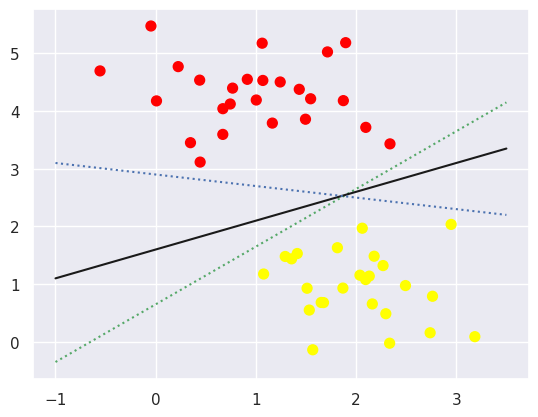

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
for m, b, c in [(1, 0.65, ':g'), (0.5, 1.6,'-k'), (-0.2, 2.9,':b')]:
    plt.plot(xfit, m * xfit + b, c)

[source](https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html)

Here the **suboptimal decision surfaces** are shown as dotted lines. Intuitively we call them suboptimal because each of them has a **higher likelihood to misclassify points** compared to the optimal decision surface shown in black.  Consider the blue dotted decision surface, on the upper left it has a high likelihood of misclassifying red points than the optimal decision surface and at the lower right is has higher likelihood of misclassifying yellow points. Conversely for the green dotted decision surface.  We can observe that the **optimal decision surface has equal likelihood to misclassify either points**.

## Maximzing the Margin

How do we construct the optimal decision surface?  One way to do this is to **maximize the margin**.  You can think of the margin as a **symmetric tube around the decision surface** that fits between the two classes. The optimal decision surface has the largest margin compared to all the other decision surfaces we can construct.

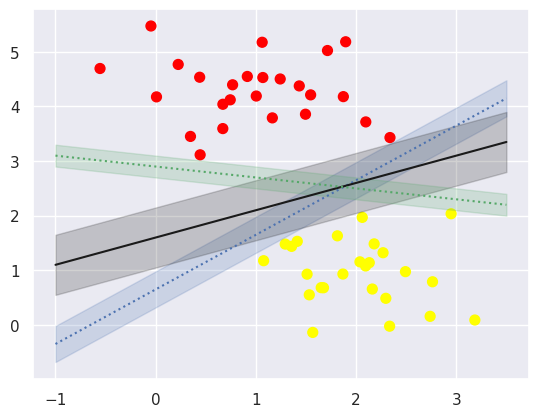

In [8]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
for m, b, d, lc, mc in [(1, 0.65, 0.33, ':b','b'), (0.5, 1.6, 0.55, '-k','k'), (-0.2, 2.9, 0.2,':g','g')]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, lc)
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color=mc, alpha=0.2)

Notice that the decision surface with the widest margin has the an equal likelihood of misclassifying points from both classes.

# Support Vector Machines

Support vector machines (SVMs) compute the maximum (optimal) margin between two classes and then place the decision surface at the center of the margin.

In [9]:
from sklearn.svm import SVC

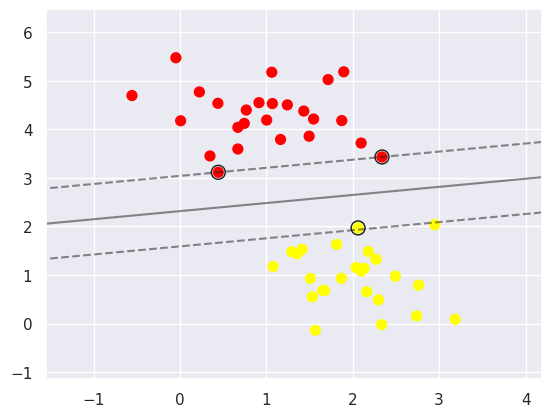

In [10]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
model = SVC(kernel='linear')
model.fit(X, y)
plot_svm_surface(model, X);

As you can see from the figure the margin is limited by points from the two classes.  These limiting points are called **support vectors**.  One way to think about these points is that they **support** the position of the optimal decision surface essentially act as **constraints** on the width and position of the optimal decision surface.

The fact we are using a **linear kernel** in our example means that we are constructing the margin and the decision surface in training data space.  If we use kernels other than the linear kernels we map our training data into  other, extremely high-dimensional spaces and build our SVMs there.  This gives rise to non-linear decision surfaces when we map the decision surface from the high-dimensional space to training data space.

## Comparing SVMs and Perceptrons

We can compare the two algorithms side-by-side.

In [11]:
from sklearn.linear_model import Perceptron
pmodel = Perceptron()
pmodel.fit(X,y)

Perceptron()

Plotting the two decision surfaces.

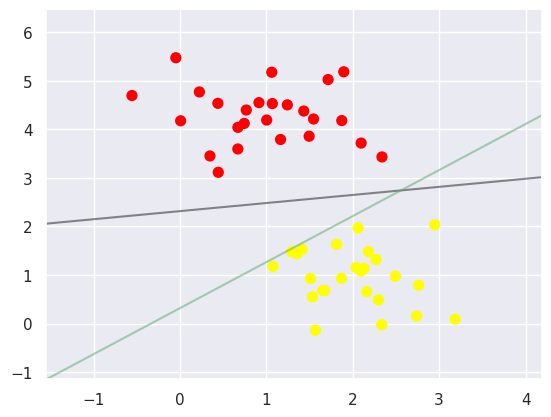

In [12]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svm_surface(model, X, surface_only=True);
plot_perceptron_surface(pmodel,X)

The decision surface for the SVM is given in black and the decision surface for the perceptron is given in green.  We can clearly see that the decision surface for the SVM is what we consider optimal.

## Dealing with Noisy Data - Soft Margins

Let regenerate our original data...

In [13]:
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)

but we will introduce a noisy point...

In [14]:
y[-5] = 0 # introducing noise

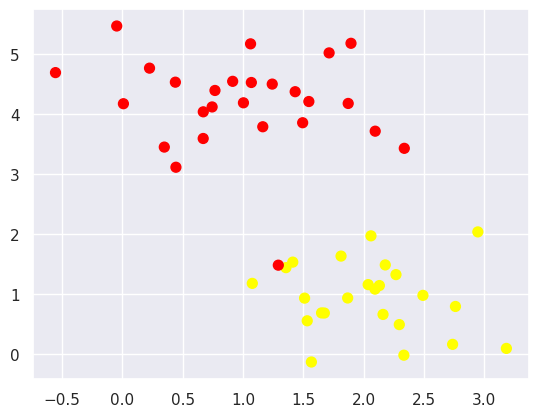

In [15]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')


Notice, there is one red point in the "wrong" class distribution.  Now let's fit an SVM with a hard margin,

In [16]:
margin_hardness = 1000

The parameter C controls the margin, here we assign it a hardness value of 1,000.

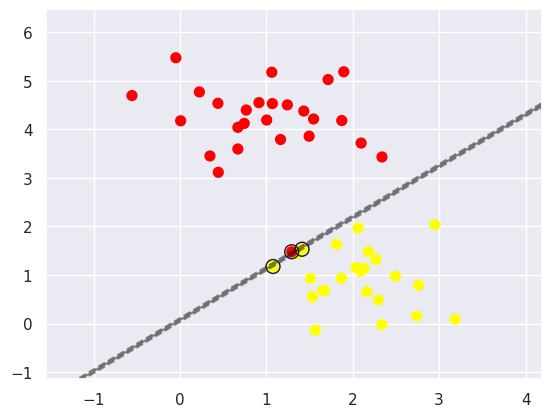

In [17]:
model = SVC(kernel='linear', C=margin_hardness)
model.fit(X, y)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svm_surface(model, X);

Notice that because of that one noisy point we obtain a suboptimal decision surface; a surface very close to the yellow class meaning that has a high likelihood to misclassify yellow points.

Now, let's set the margin hardness to 1 meaning that the margin construction should "ignore" noisy points.

In [18]:
margin_hardness = 1

Again, we set the C parameter to our margin hardness for fitting,

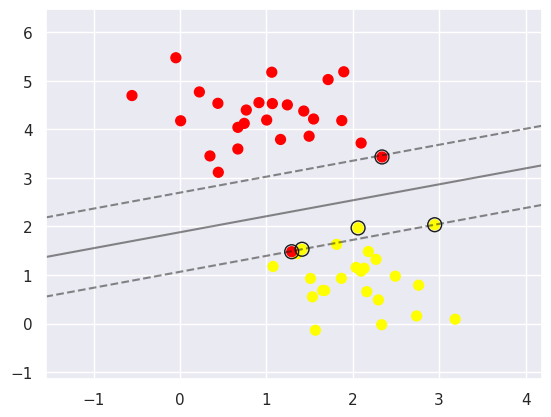

In [19]:
model = SVC(kernel='linear', C=margin_hardness)
model.fit(X, y)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svm_surface(model, X);

Notice that we regained a margin that is optimal or close to optimal.  Also notice that the noisy point is on the "wrong" side of the decision surface.  In essence, the margin construction ingnored the noisy point in favor of a more optimal decision surface.  Exactly the kind of result we would like to see in noisy data.

Note that the default for SVMs is `C=1`, that is, by default the construction uses soft margins.

## Nonlinear Data

Not all data is separable by a linear decision surface.  For example, in the extreme case where one class is embedded in another class, like so,

In [20]:
X, y = make_circles(100, factor=.1, noise=.1)

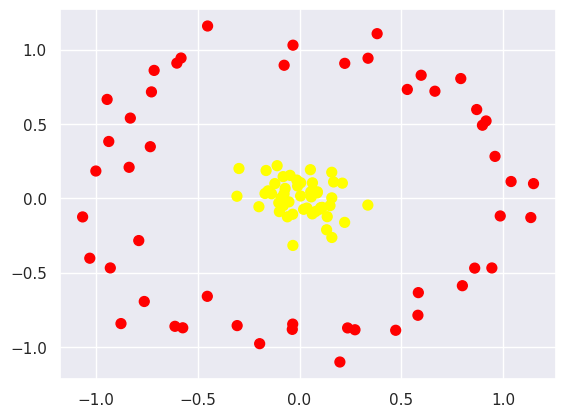

In [21]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

Here we can use **kernels** to map our training data into a higher-dimensional space where it is most likely possible to build a linear classifier.  When projecting the linear decision surface from the higher-dimensional space back into the lower-dimensional space of the training data the decision surface seems non-linear.

Let's use the **radial basis function (rbf)** kernel.  We will also use a **hard margin** because we know that the two classes are well separated.



In [22]:
model = SVC(kernel='rbf', C=1000)
model.fit(X, y)

SVC(C=1000)

Let's visualize this decision surface in our training data space.

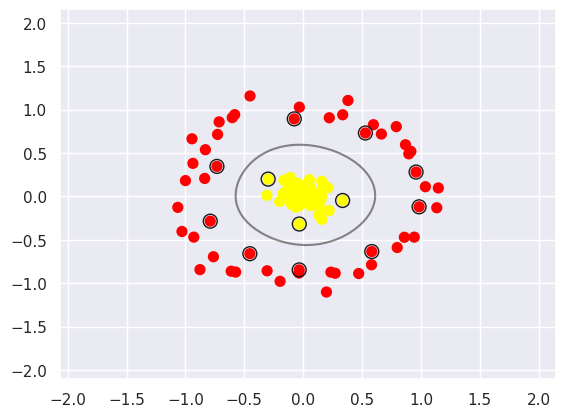

In [23]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svm_surface(model,X,surface_only=True)
plot_svm_surface(model,X,support_only=True)

Even though we are building a linear decision surface in radial basis function space, when projecting it back into training data space it appear non-linear!

# Example: Text Classification

In [24]:
# data handling
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split

# model
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from confint import classification_confint

In [25]:
# get the newsgroup database
newsgroups = pd.read_csv(home+"newsgroups-noheaders.csv")
newsgroups.head(n=10)

,text,label
0,\nIn billions of dollars (%GNP):\nyear GNP ...,space
1,ajteel@dendrite.cs.Colorado.EDU (A.J. Teel) w...,space
2,\nMy opinion is this: In a society whose econ...,space
3,"Ahhh, remember the days of Yesterday? When we...",space
4,"\n""...a la Chrysler""?? Okay kids, to the near...",space
5,"\n As for advertising -- sure, why not? A N...",politics
6,"\n What, pray tell, does this mean? Just who ...",space
7,\nWhere does the shadow come from? There's no...,politics
8,^^^^^^^^^...,politics
9,"#Yet, when a law was proposed for Virginia tha...",space


In [26]:
# construct the docterm matrix

# build the stemmer object
stemmer = PorterStemmer()

# build a new default analyzer using CountVectorizer that only
# uses words, [a-zA-Z]+, and also eliminates stop words
analyzer= CountVectorizer(analyzer = "word",
                          stop_words = 'english',
                          token_pattern = "[a-zA-Z]+").build_analyzer()

# build a new analyzer that stems using the default analyzer to
# create the words to be stemmed
def stemmed_words(doc):
    return [stemmer.stem(w) for w in analyzer(doc)]

# build docarray
vectorizer = CountVectorizer(analyzer=stemmed_words,
                             binary=True,
                             min_df=2) # each word has to appear at least twice
docarray = vectorizer.fit_transform(newsgroups['text']).toarray()
docterm = pd.DataFrame(docarray, columns=list(vectorizer.get_feature_names_out()))
print("We have {} articles with {} features".format(docterm.shape[0],docterm.shape[1]))
docterm.head()

We have 1038 articles with 6045 features


,aa,abandon,abbey,abc,abil,abl,aboard,abolish,abort,abroad,...,yugoslavia,yup,z,zealand,zenit,zero,zeta,zip,zone,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [27]:
# set up train and test sets
X_train, X_test, y_train, y_test = \
  train_test_split(docterm,   # as X
                   newsgroups['label'],  # as y
                   train_size=0.8,
                   test_size=0.2,
                   random_state=2)

In [28]:
# train model

# model object
model = SVC(kernel='rbf')

# grid search
param_grid = {
      'kernel':['linear','rbf'],
      'C': [10, 100, 1000],
      'gamma': [0.0001, 0.001, 0.01]
}
grid = GridSearchCV(model, param_grid, cv=3, verbose=10, n_jobs=-1)
grid.fit(X_train, y_train)
print("Grid Search: best parameters: {}".format(grid.best_params_))
best_model = grid.best_estimator_

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Grid Search: best parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


In [29]:
# Evaluate the best model
predict_y = best_model.predict(X_test)
acc = accuracy_score(y_test, predict_y)
lb,ub = classification_confint(acc,X_test.shape[0])
print("Accuracy: {:3.2f} ({:3.2f},{:3.2f})".format(acc,lb,ub))

Accuracy: 0.88 (0.84,0.93)


In [30]:
# build the confusion matrix
labels = ['politics','space']
cm = confusion_matrix(y_test, predict_y, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
cm_df

,politics,space
politics,100,9
space,15,84


Putting this into context with all the other classifiers we tried on this dataset:

**decision tree**: Accuracy: 0.74 (0.68,0.80)

**SVM**: Accuracy: 0.88 (0.84,0.93)

**random forest**: Accuracy: 0.90 (0.86,0.94)

**gradient boosting**: Accuracy: 0.91 (0.87,0.95)

**naive bayes**: 0.96 (0.93,0.98)


# Example: Handwritten Digit Classification

In [31]:
# we need UCI repo access
!pip install ucimlrepo

import numpy as np # we need numpy arrays
from ucimlrepo import fetch_ucirepo

In [32]:
# fetch dataset
digits = fetch_ucirepo(id=80)

# data (as pandas dataframes)
X = digits.data.features
X.head()

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,...,Attribute55,Attribute56,Attribute57,Attribute58,Attribute59,Attribute60,Attribute61,Attribute62,Attribute63,Attribute64
0,0,1,6,15,12,1,0,0,0,7,...,0,0,0,0,6,14,7,1,0,0
1,0,0,10,16,6,0,0,0,0,7,...,3,0,0,0,10,16,15,3,0,0
2,0,0,8,15,16,13,0,0,0,1,...,0,0,0,0,9,14,0,0,0,0
3,0,0,0,3,11,16,0,0,0,0,...,0,0,0,0,0,1,15,2,0,0
4,0,0,5,14,4,0,0,0,0,0,...,12,0,0,0,4,12,14,7,0,0


In [33]:
y = digits.data.targets
y.head()

,class
0,0
1,0
2,7
3,4
4,6


There is support for all of the 10 digits.

In [36]:
y.value_counts()

class
3        572
1        571
4        568
7        566
9        562
5        558
6        558
2        557
0        554
8        554
Name: count, dtype: int64

Note that this is a 10-way classification problem.  A single SVM can only discriminate two classes. The sklearn SVM implementation deals with it by building one SVM for each class (digit in this case) and then uses an aggregation scheme to come up with a single classification.

In [37]:
# setting up training/testing data
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y['class'], # we want a series as target
    train_size=0.8,
    test_size=0.2,
    random_state=1
)

In [38]:
# train model

# model object
model = SVC(kernel='rbf')

# grid search
param_grid = {
      'kernel':['linear','rbf'],
      'C': [1, 10, 100, 1000],
      'gamma': [0.0001, 0.001, 0.01, 0.1]
}
grid = GridSearchCV(model, param_grid, cv=3, verbose=10, n_jobs=-1)
grid.fit(X_train, y_train)
print("Grid Search: best parameters: {}".format(grid.best_params_))
best_model = grid.best_estimator_

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Grid Search: best parameters: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}


In [39]:
# Evaluate the best model
predict_y = best_model.predict(X_test)
acc = accuracy_score(y_test, predict_y)
lb,ub = classification_confint(acc,X_test.shape[0])
print("Accuracy: {:3.2f} ({:3.2f},{:3.2f})".format(acc,lb,ub))

Accuracy: 0.99 (0.99,1.00)


In [40]:
# build the confusion matrix
cm = confusion_matrix(y_test, predict_y)
cm_df = pd.DataFrame(cm)
cm_df

,0,1,2,3,4,5,6,7,8,9
0,105,0,0,0,0,0,0,0,0,0
1,0,129,0,0,0,0,0,1,0,0
2,0,0,91,0,0,0,0,0,0,0
3,0,0,0,118,0,0,0,0,0,0
4,0,0,0,0,107,0,0,1,0,0
5,0,0,0,0,0,96,0,0,0,0
6,0,0,0,0,1,0,111,0,0,0
7,0,0,0,1,0,0,0,129,0,0
8,0,1,0,0,1,0,0,0,118,1
9,0,0,0,0,0,0,0,0,0,113


Again, putting the SVM results in the context of our previous results,

**decision tree**: 0.92 (0.90, 0.93)

**random forest**: 0.98 (0.98,0.99)

**gradient boosting**: 0.99 (0.98,0.99)

**SVM**: 0.99 (0.99,1.00)

